In [1]:
import sys, os
everestPath = os.path.abspath('everest')
if not everestPath in sys.path:
    sys.path.insert(0, everestPath)

In [2]:
from everest import window
%matplotlib inline

In [3]:
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier

In [4]:
from everest.h5anchor import Reader, Fetch
F = lambda key: Fetch(f"*/{key}")
reader = Reader('obsvisc', '.')

In [5]:
cut = reader[
    (F('temperatureField') == '_built_peaskauslu-thoesfthuec') \
    & (F('aspect') == 1) & (F('f') == 1) \
#     & (F('t') > 0.3) & (F('t') < 0.4)
    ]

In [6]:
paramkeys = (
    'tauRef',
#     'f',
#     'aspect',
#     'etaDelta',
#     'etaRef',
#     'alpha',
#     'H',
#     'flux',
#     'kappa',
    )
datakeys = (
#     't',
    'dt',
    'Nu',
    'Nu_freq',
    'Nu_min',
    'Nu_range',
    'VRMS',
    'strainRate_outer_av',
    'strainRate_outer_min',
    'strainRate_outer_range',
    'stressAng_outer_av',
    'stressAng_outer_min',
    'stressAng_outer_range',
    'stressRad_outer_av',
    'stressRad_outer_min',
    'stressRad_outer_range',
    'temp_av',
    'temp_min',
    'temp_range',
    'velAng_outer_av',
    'velAng_outer_min',
    'velAng_outer_range',
    'velMag_range',
    'visc_av',
    'visc_min',
    'visc_range',
    'yieldFrac'
    )
params = reader[cut : paramkeys]
datas = reader[cut : datakeys]

In [7]:
allkeys = tuple([*paramkeys, *datakeys])
X = [[] for _ in range(len(allkeys))]
y = [[] for _ in range(len(allkeys))]
for k, subdatas in sorted(datas.items()):
    subparams = params[k]
    if not len(set([len(d) for d in subdatas])) == 1:
        continue
    length = len(subdatas[0])
    if not length:
        continue
    ps = [np.full(length, p) for p in subparams]
    allds = [*ps, *subdatas]
    for i, d in enumerate(allds):
        X[i].extend(d[:-2])
        y[i].extend(d[1:-1])
X = np.array(X).T
y = np.array(y).T

In [8]:
reg = LinearRegression().fit(X, y)
def predict_future_Nu(sampleno, n = 300):
    Nuk = allkeys.index('Nu')
    frame = X[sampleno]
    Nus = [frame[Nuk],]
    for i in range(n):
        frame = reg.predict([frame,])[0]
        Nus.append(frame[Nuk])
    return Nus

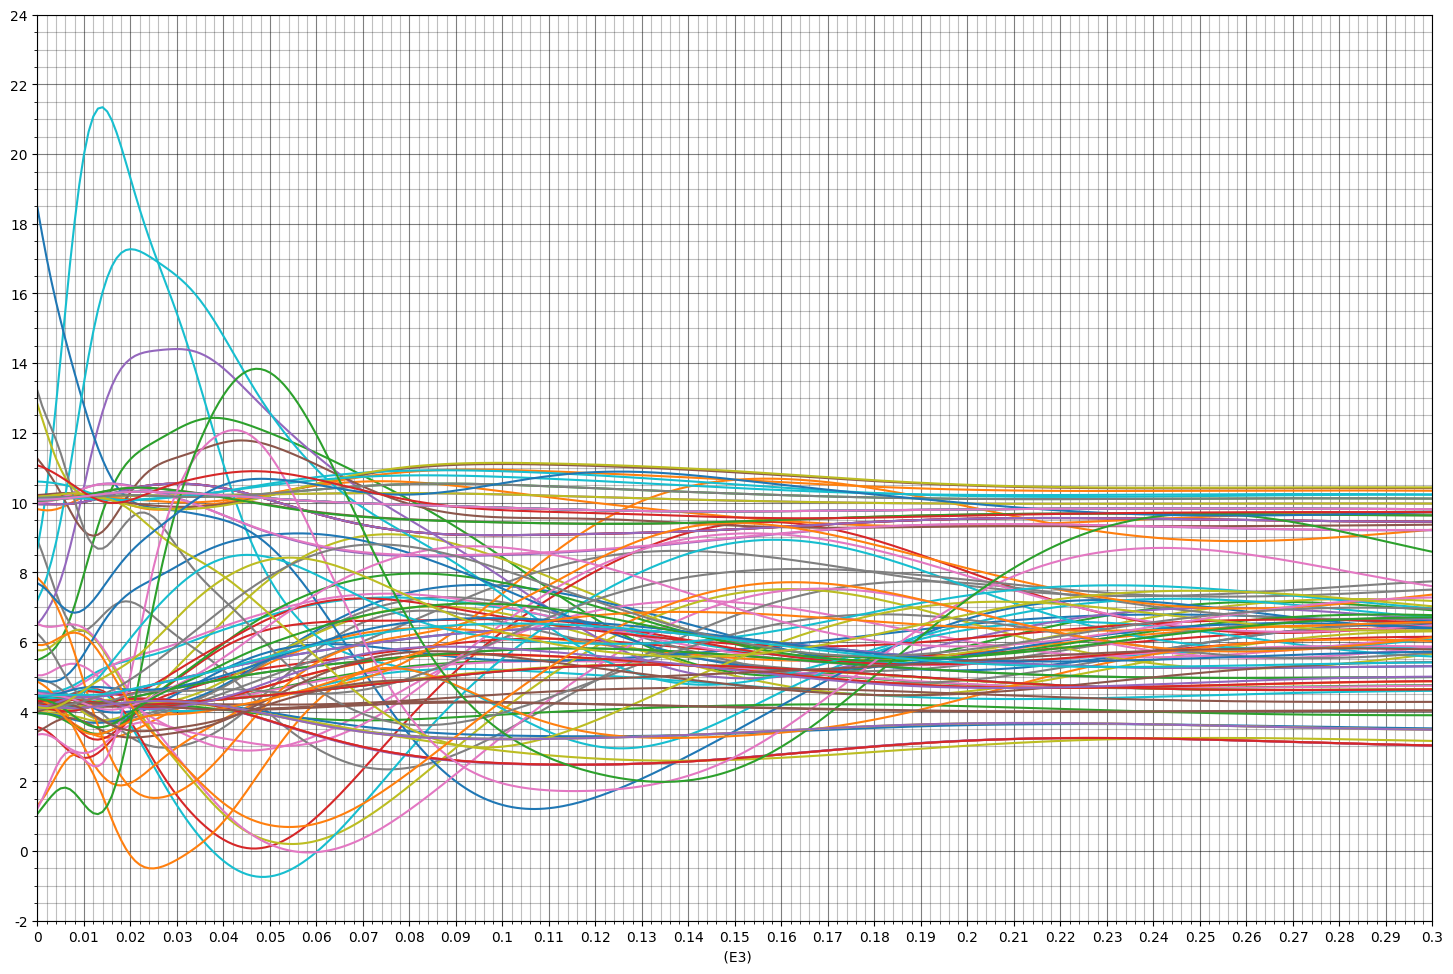

In [9]:
canvas = window.Canvas(size = (18, 12))
ax = canvas.make_ax()
for _ in range(100):
    i = np.random.randint(X.shape[0])
    Nu = predict_future_Nu(i)
    t = np.arange(len(Nu))
    ax.line(t, Nu, alpha = 0.5)
canvas.show()

In [10]:
# scaler = preprocessing.StandardScaler()
# tx = scaler.fit_transform(x, y)
# clf = MLPClassifier().fit(tx, y)